In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from pathlib import Path

from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics

from pytorch_lightning.strategies import DDPStrategy

from paper_utils import LightningResNet18

import configparser
from paper_utils import PoincareDataModule

In [2]:
isBool = lambda x: x.lower() == "true"
converters = {'IntList': lambda x: [int(i.strip()) for i in x.strip(" [](){}").split(',')],
    'FloatList': lambda x: [float(i.strip()) for i in x.strip(" [](){}").split(',')],
    'BoolList': lambda x: [isBool(i.strip()) for i in x.strip(" [](){}").split(',')]}
config = configparser.ConfigParser(converters=converters)

In [3]:
config.read("./configs/model_training/SAM_study.cfg")
# LOGGING params
# -------------------------------------------------------
log_dir = config.get('LOGGING', 'log_dir')
name = config.get('LOGGING', 'name')
# -------------------------------------------------------
# HARDWARE params  
# -------------------------------------------------------  
num_workers = config.getint('HARDWARE', 'num_workers')
auto_select_gpus = config.getboolean('HARDWARE', 'auto_select_gpus')
num_gpus = config.getint('HARDWARE', 'num_gpus')

if auto_select_gpus==True:
    devices = num_gpus
else:
    devices = config.getIntList("HARDWARE", "devices")
if devices > 1:
    num_workers = 0
    strategy = DDPStrategy(find_unused_parameters=False)
else:
    num_workers = num_workers
    strategy = None
# -------------------------------------------------------
# DATAMODULE params
# -------------------------------------------------------
data_dir = config.get('DATAMODULE', 'data_dir')
main_lookup_dir = config.get('DATAMODULE', 'main_lookup_dir')
local_lookup_dir = config.get('DATAMODULE', 'local_lookup_dir')
batch_size = config.getint('DATAMODULE', 'batch_size')
img_widths = config.getIntList('DATAMODULE', 'img_width')
alpha = config.getfloat('DATAMODULE', 'alpha')
min_samples = config.getint('DATAMODULE', 'min_samples', fallback=0)
max_samples = config.getint('DATAMODULE', 'max_samples', fallback=-1)
min_traj_len = config.getint('DATAMODULE', 'min_traj_len')
max_traj_len = config.getint('DATAMODULE', 'max_traj_len')
num_params = config.getint('DATAMODULE', 'num_params')
if ("param_min" in config['DATAMODULE']) or ("param_max" in config['DATAMODULE']):
    if not (("param_min" in config['DATAMODULE']) and ("param_max" in config['DATAMODULE'])):
        raise ValueError("Must specify both param_min and param_max, or neither")
    else:
        param_min = np.array(config.getFloatList('DATAMODULE', 'param_min'))
        param_max = np.array(config.getFloatList('DATAMODULE', 'param_max'))
        assert(num_params == len(param_min) == len(param_max))
else:
    param_min = None
    param_max = None

coords = config.getIntList('DATAMODULE', 'coords', fallback=[0,1])
print(f"{coords=}")
x_range = config.getFloatList('DATAMODULE', 'x_range', fallback=None)
y_range = config.getFloatList('DATAMODULE', 'y_range', fallback=None)

coords=[0, 2]


In [4]:
trainer = pl.Trainer(
    logger=False,
    accelerator='gpu',
    devices=devices,
    num_sanity_val_steps=0,
    deterministic=True,
    auto_select_gpus=auto_select_gpus,
    enable_progress_bar=False
)

assert(len(img_widths) == 1)

sample_frac = .5

aug_datamodule = PoincareDataModule(
                    local_lookup_dir=local_lookup_dir,
                    data_dir=data_dir,
                    coords=coords,
                    sample_frac=sample_frac,
                    img_width=img_widths[0],
                    batch_size=batch_size, 
                    x_range=x_range,
                    y_range=y_range,
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=min_traj_len,
                    max_traj_len=max_traj_len,
                    num_workers=num_workers,
                    verbose=True,
                    randomize=True,
                )
                    
non_aug_datamodule = PoincareDataModule(
                local_lookup_dir=local_lookup_dir,
                data_dir=data_dir,
                coords=coords,
                sample_frac=sample_frac,
                img_width=img_widths[0],
                batch_size=batch_size, 
                x_range=x_range,
                y_range=y_range,
                alpha=alpha,
                min_samples=min_samples,
                max_samples=max_samples,
                min_traj_len=min_traj_len,
                max_traj_len=max_traj_len,
                num_workers=num_workers,
                verbose=True,
                randomize=False,
            )

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


In [5]:
df_list = []
p = Path(log_dir)
for i in p.rglob('*version_0/'):
    print(i.parent.name)
    hparam_dict = yaml.load(open(i / 'hparams.yaml'), yaml.FullLoader)
    num_train = hparam_dict['num_train']
    randomized = hparam_dict['randomize']
    print(f"{num_train=}, {randomized=}")
    for child in i.parent.iterdir():
        if child.is_dir():
            for j in child.iterdir():
                if j.is_dir():
                    for model_ckpt in j.iterdir():
                        print(f"{model_ckpt.name=}")
                        model = LightningResNet18.load_from_checkpoint(model_ckpt.resolve())
                        datamodule = aug_datamodule if randomized else non_aug_datamodule
                        test_loss = trainer.test(model=model, dataloaders=datamodule.test_dataloader(), verbose=False)[0]["val_mse"]
                        df_list.append({"loss": test_loss, "num_train": num_train, "Train Augmentation": randomized})
SAM_df = pd.DataFrame(df_list)

SAM__sample_frac_1.00
num_train=7680, randomized=False
model_ckpt.name='epoch=94-val_mse=1.27e-03_randomized_False.ckpt'


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=80-val_mse=1.51e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=95-val_mse=1.27e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_1.00
num_train=7680, randomized=True
model_ckpt.name='epoch=88-val_mse=5.34e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=101-val_mse=4.94e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=100-val_mse=4.45e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.50
num_train=3840, randomized=False
model_ckpt.name='epoch=198-val_mse=2.50e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=190-val_mse=2.87e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=174-val_mse=3.68e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.50
num_train=3840, randomized=True
model_ckpt.name='epoch=196-val_mse=5.07e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=204-val_mse=4.77e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=164-val_mse=5.54e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.25
num_train=1920, randomized=False
model_ckpt.name='epoch=410-val_mse=4.81e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=361-val_mse=2.87e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=276-val_mse=3.78e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.25
num_train=1920, randomized=True
model_ckpt.name='epoch=370-val_mse=5.30e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=390-val_mse=5.09e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=415-val_mse=5.67e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.06
num_train=480, randomized=False
model_ckpt.name='epoch=939-val_mse=1.18e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=615-val_mse=2.23e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=996-val_mse=1.73e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.06
num_train=480, randomized=True
model_ckpt.name='epoch=1592-val_mse=4.34e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1238-val_mse=4.99e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=1664-val_mse=5.34e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.02
num_train=120, randomized=False
model_ckpt.name='epoch=4465-val_mse=9.97e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3794-val_mse=4.20e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=5770-val_mse=8.45e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.02
num_train=120, randomized=True
model_ckpt.name='epoch=5051-val_mse=7.03e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=5724-val_mse=7.60e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=4709-val_mse=5.89e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.03
num_train=240, randomized=False
model_ckpt.name='epoch=2743-val_mse=6.22e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2125-val_mse=2.97e-02_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=650-val_mse=1.21e-01_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.03
num_train=240, randomized=True
model_ckpt.name='epoch=2496-val_mse=6.36e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=3031-val_mse=6.50e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=2932-val_mse=7.99e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.12
num_train=960, randomized=False
model_ckpt.name='epoch=563-val_mse=6.15e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=724-val_mse=5.89e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=681-val_mse=5.47e-03_randomized_False.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


SAM__sample_frac_0.12
num_train=960, randomized=True
model_ckpt.name='epoch=773-val_mse=3.48e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=813-val_mse=4.38e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


model_ckpt.name='epoch=770-val_mse=4.72e-03_randomized_True.ckpt'


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


In [6]:
# df_list = []
# p = Path(log_dir)
# for i in p.rglob('*.yaml'):
#     # parse file to get number of training samples used, and whether or not it was randomized
#     hparam_dict = yaml.safe_load(i.open())
#     num_train = hparam_dict['num_train']
#     randomized = hparam_dict['randomize']
#     print(f"{num_train=}, {randomized=}")
#     for child in i.parent.iterdir():
#         if child.is_dir():
#             for model_ckpt in child.iterdir():
#                 model = LightningResNet18.load_from_checkpoint(model_ckpt.resolve())
#                 datamodule = aug_datamodule if randomized else non_aug_datamodule
#                 test_loss = trainer.test(model=model, dataloaders=datamodule.test_dataloader(), verbose=False)[0]["val_mse"]
#                 df_list.append({"loss": test_loss, "num_train": num_train, "Train Augmentation": randomized})
# SAM_df = pd.DataFrame(df_list)

In [7]:
import seaborn as sns

LINE_PLOT_BLACK = ".2"
BAR_PLOT_ORANGE = (0.34705882352941175, 0.4588235294117645, 0.6411764705882353, 1.0)
LINE_PLOT_ORANGE = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
HATCH = "/"

sns.set_theme(context="paper", style="ticks", font_scale=1.75)

# update line plot markers
def fix_lineplot_markers(plot):
    for line in plot.get_lines():
        if line.get_color() == LINE_PLOT_BLACK:
            line.set_marker('')
        else:
            line.set_marker('o')
            line.set_markeredgecolor('k')
            line.set_markersize(10)
            if line.get_color() == LINE_PLOT_ORANGE:
                line.set_marker('D')

# update barplot patches
def fix_barplot_patches(plot):
    for thisbar in plot.patches:
        thisbar.set_edgecolor('k')
        if thisbar._facecolor == BAR_PLOT_ORANGE:
            thisbar.set_hatch(HATCH)

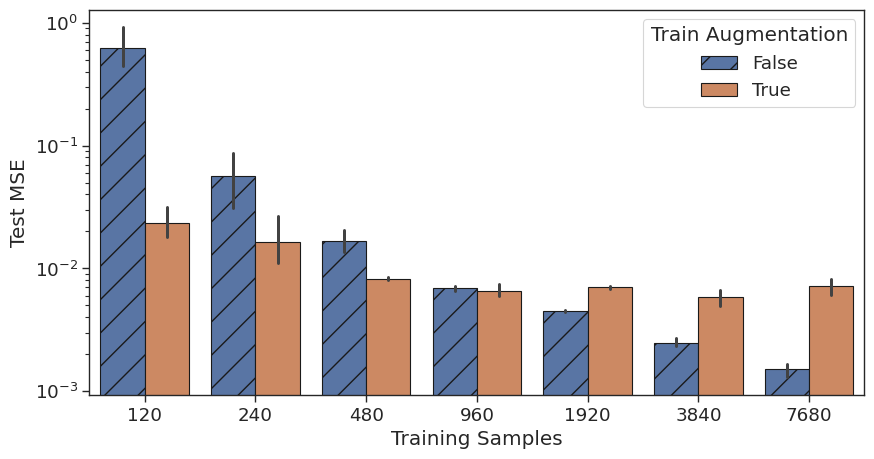

In [8]:
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_yscale("log")
# df = pd.read_csv("sample_efficiency_trials.csv")
plot = sns.barplot(data=SAM_df, x="num_train", y="loss", hue="Train Augmentation")

fix_barplot_patches(plot)
ax.set_yscale('log')
ax.set_xlabel("Training Samples")
ax.set_ylabel("Test MSE")
ax.legend(title="Train Augmentation", loc='upper right')

plt.savefig("SAM_bargraph.pdf", bbox_inches="tight")

In [16]:
augmented_models = []
non_augmented_models = []

p = Path(log_dir)
for i in p.rglob('*SAM__sample_frac_1.00/'):
    print(i.name)
    if i.is_dir():
        for child in i.rglob("*.ckpt"):
            print(child.name)
            if (child.name.strip(".ckpt").split("_")[-1]) == "True":
                augmented_models.append(LightningResNet18().load_from_checkpoint(child.resolve()))
            else:
                non_augmented_models.append(LightningResNet18().load_from_checkpoint(child.resolve()))


SAM__sample_frac_1.00
epoch=94-val_mse=1.27e-03_randomized_False.ckpt


/home/connorsteph/miniconda3/envs/DL_PSI_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch=80-val_mse=1.51e-03_randomized_False.ckpt
epoch=95-val_mse=1.27e-03_randomized_False.ckpt
SAM__sample_frac_1.00
epoch=88-val_mse=5.34e-03_randomized_True.ckpt
epoch=101-val_mse=4.94e-03_randomized_True.ckpt
epoch=100-val_mse=4.45e-03_randomized_True.ckpt


In [17]:
traj_lengths = [33, 66, 112, 225, 450, 900]

# augmented_models = [LightningResNet18().load_from_checkpoint('/scratch-a/connorsteph/paper_experiments/henon_map/num_samples_10000/img_width_128/randomized_True/num_samples_10000/version_0/checkpoints/epoch=461-val_mse=1.51e-02_randomized_True.ckpt')]
# non_augmented_models = [LightningResNet18().load_from_checkpoint('/scratch-a/connorsteph/paper_experiments/henon_map/num_samples_10000/img_width_128/randomized_False/num_samples_10000/version_0/checkpoints/epoch=380-val_mse=5.18e-03_randomized_False.ckpt')]


df_list = []

sample_frac = .5

for t in traj_lengths:
    print(t)
    np.random.seed(42)
    torch.manual_seed(42)
    aug_datamodule = PoincareDataModule(
                        local_lookup_dir=local_lookup_dir,
                        data_dir=data_dir,
                        coords=coords,
                        sample_frac=sample_frac,
                        img_width=img_widths[0],
                        batch_size=batch_size, 
                        x_range=x_range,
                        y_range=y_range,
                        alpha=alpha,
                        min_samples=min_samples,
                        max_samples=max_samples,
                        min_traj_len=min_traj_len,
                        max_traj_len=t,
                        num_workers=num_workers,
                        verbose=True,
                        randomize=True,
                    )
    np.random.seed(42)
    torch.manual_seed(42)
    non_aug_datamodule = PoincareDataModule(
                    local_lookup_dir=local_lookup_dir,
                    data_dir=data_dir,
                    coords=coords,
                    sample_frac=sample_frac,
                    img_width=img_widths[0],
                    batch_size=batch_size, 
                    x_range=x_range,
                    y_range=y_range,
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=min_traj_len,
                    max_traj_len=t,
                    num_workers=num_workers,
                    verbose=True,
                    randomize=False,
                )
    
    for augmented_model, non_augmented_model in zip(augmented_models, non_augmented_models):
        aug_aug_loss = trainer.test(model=augmented_model, dataloaders=aug_datamodule, verbose=False)[0]['val_mse']    
        aug_non_loss = trainer.test(model=augmented_model, dataloaders=non_aug_datamodule, verbose=False)[0]['val_mse']
        non_aug_loss = trainer.test(model=non_augmented_model, dataloaders=aug_datamodule, verbose=False)[0]['val_mse']
        non_non_loss = trainer.test(model=non_augmented_model, dataloaders=non_aug_datamodule, verbose=False)[0]['val_mse']
        print(f"{aug_aug_loss=}, {aug_non_loss=}, {non_aug_loss=}, {non_non_loss=}")
        df_list.append({"traj_len": t, "Training Augmentation":True, "Testing Augmentation":True, "Loss":aug_aug_loss})
        df_list.append({"traj_len": t, "Training Augmentation":True, "Testing Augmentation":False, "Loss":aug_non_loss})
        df_list.append({"traj_len": t, "Training Augmentation":False, "Testing Augmentation":True, "Loss":non_aug_loss})
        df_list.append({"traj_len": t, "Training Augmentation":False, "Testing Augmentation":False, "Loss":non_non_loss})

df = pd.DataFrame(df_list)
df.to_csv("SAM_length_generalization_study.csv")

33
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=2.3329098224639893, aug_non_loss=1.5091009140014648, non_aug_loss=26.28413963317871, non_non_loss=24.20513343811035


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=2.5304315090179443, aug_non_loss=2.4721755981445312, non_aug_loss=22.716163635253906, non_non_loss=26.23841667175293


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=2.3753163814544678, aug_non_loss=1.7983068227767944, non_aug_loss=28.64629554748535, non_non_loss=25.897932052612305
66
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.20467311143875122, aug_non_loss=0.09109003096818924, non_aug_loss=26.708715438842773, non_non_loss=23.003095626831055


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.28521493077278137, aug_non_loss=0.1417931169271469, non_aug_loss=26.00757598876953, non_non_loss=24.760740280151367


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.4007401168346405, aug_non_loss=0.15367193520069122, non_aug_loss=29.187868118286133, non_non_loss=26.145551681518555
112
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.02311003766953945, aug_non_loss=0.0058862208388745785, non_aug_loss=23.098276138305664, non_non_loss=5.385558605194092


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.014941833913326263, aug_non_loss=0.007079312577843666, non_aug_loss=24.11225700378418, non_non_loss=8.540517807006836


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.015168637968599796, aug_non_loss=0.004957361146807671, non_aug_loss=26.04866600036621, non_non_loss=8.397200584411621
225
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.006127500906586647, aug_non_loss=0.004193581640720367, non_aug_loss=12.754237174987793, non_non_loss=0.0022408796939998865


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.007539583835750818, aug_non_loss=0.0033659532200545073, non_aug_loss=13.846989631652832, non_non_loss=0.0029149341862648726


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.006035500671714544, aug_non_loss=0.002077629556879401, non_aug_loss=14.66378116607666, non_non_loss=0.0016435381257906556
450
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.005026947241276503, aug_non_loss=0.003769033821299672, non_aug_loss=6.7872314453125, non_non_loss=0.022039689123630524


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.006803456228226423, aug_non_loss=0.003968026023358107, non_aug_loss=7.387998104095459, non_non_loss=0.008789822459220886


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.003918010275810957, aug_non_loss=0.002881303196772933, non_aug_loss=7.955587863922119, non_non_loss=0.0045931111089885235
900
Loading dataset:
Using data augmentation
Training set...
Validation set...
Test set...
Dataset loaded.
Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.005263319239020348, aug_non_loss=0.008721588179469109, non_aug_loss=3.8905746936798096, non_non_loss=0.032269325107336044


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.009876038879156113, aug_non_loss=0.01489472109824419, non_aug_loss=4.299045562744141, non_non_loss=0.01757129281759262


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]


aug_aug_loss=0.008241144940257072, aug_non_loss=0.09751474857330322, non_aug_loss=4.428118705749512, non_non_loss=0.009386342018842697


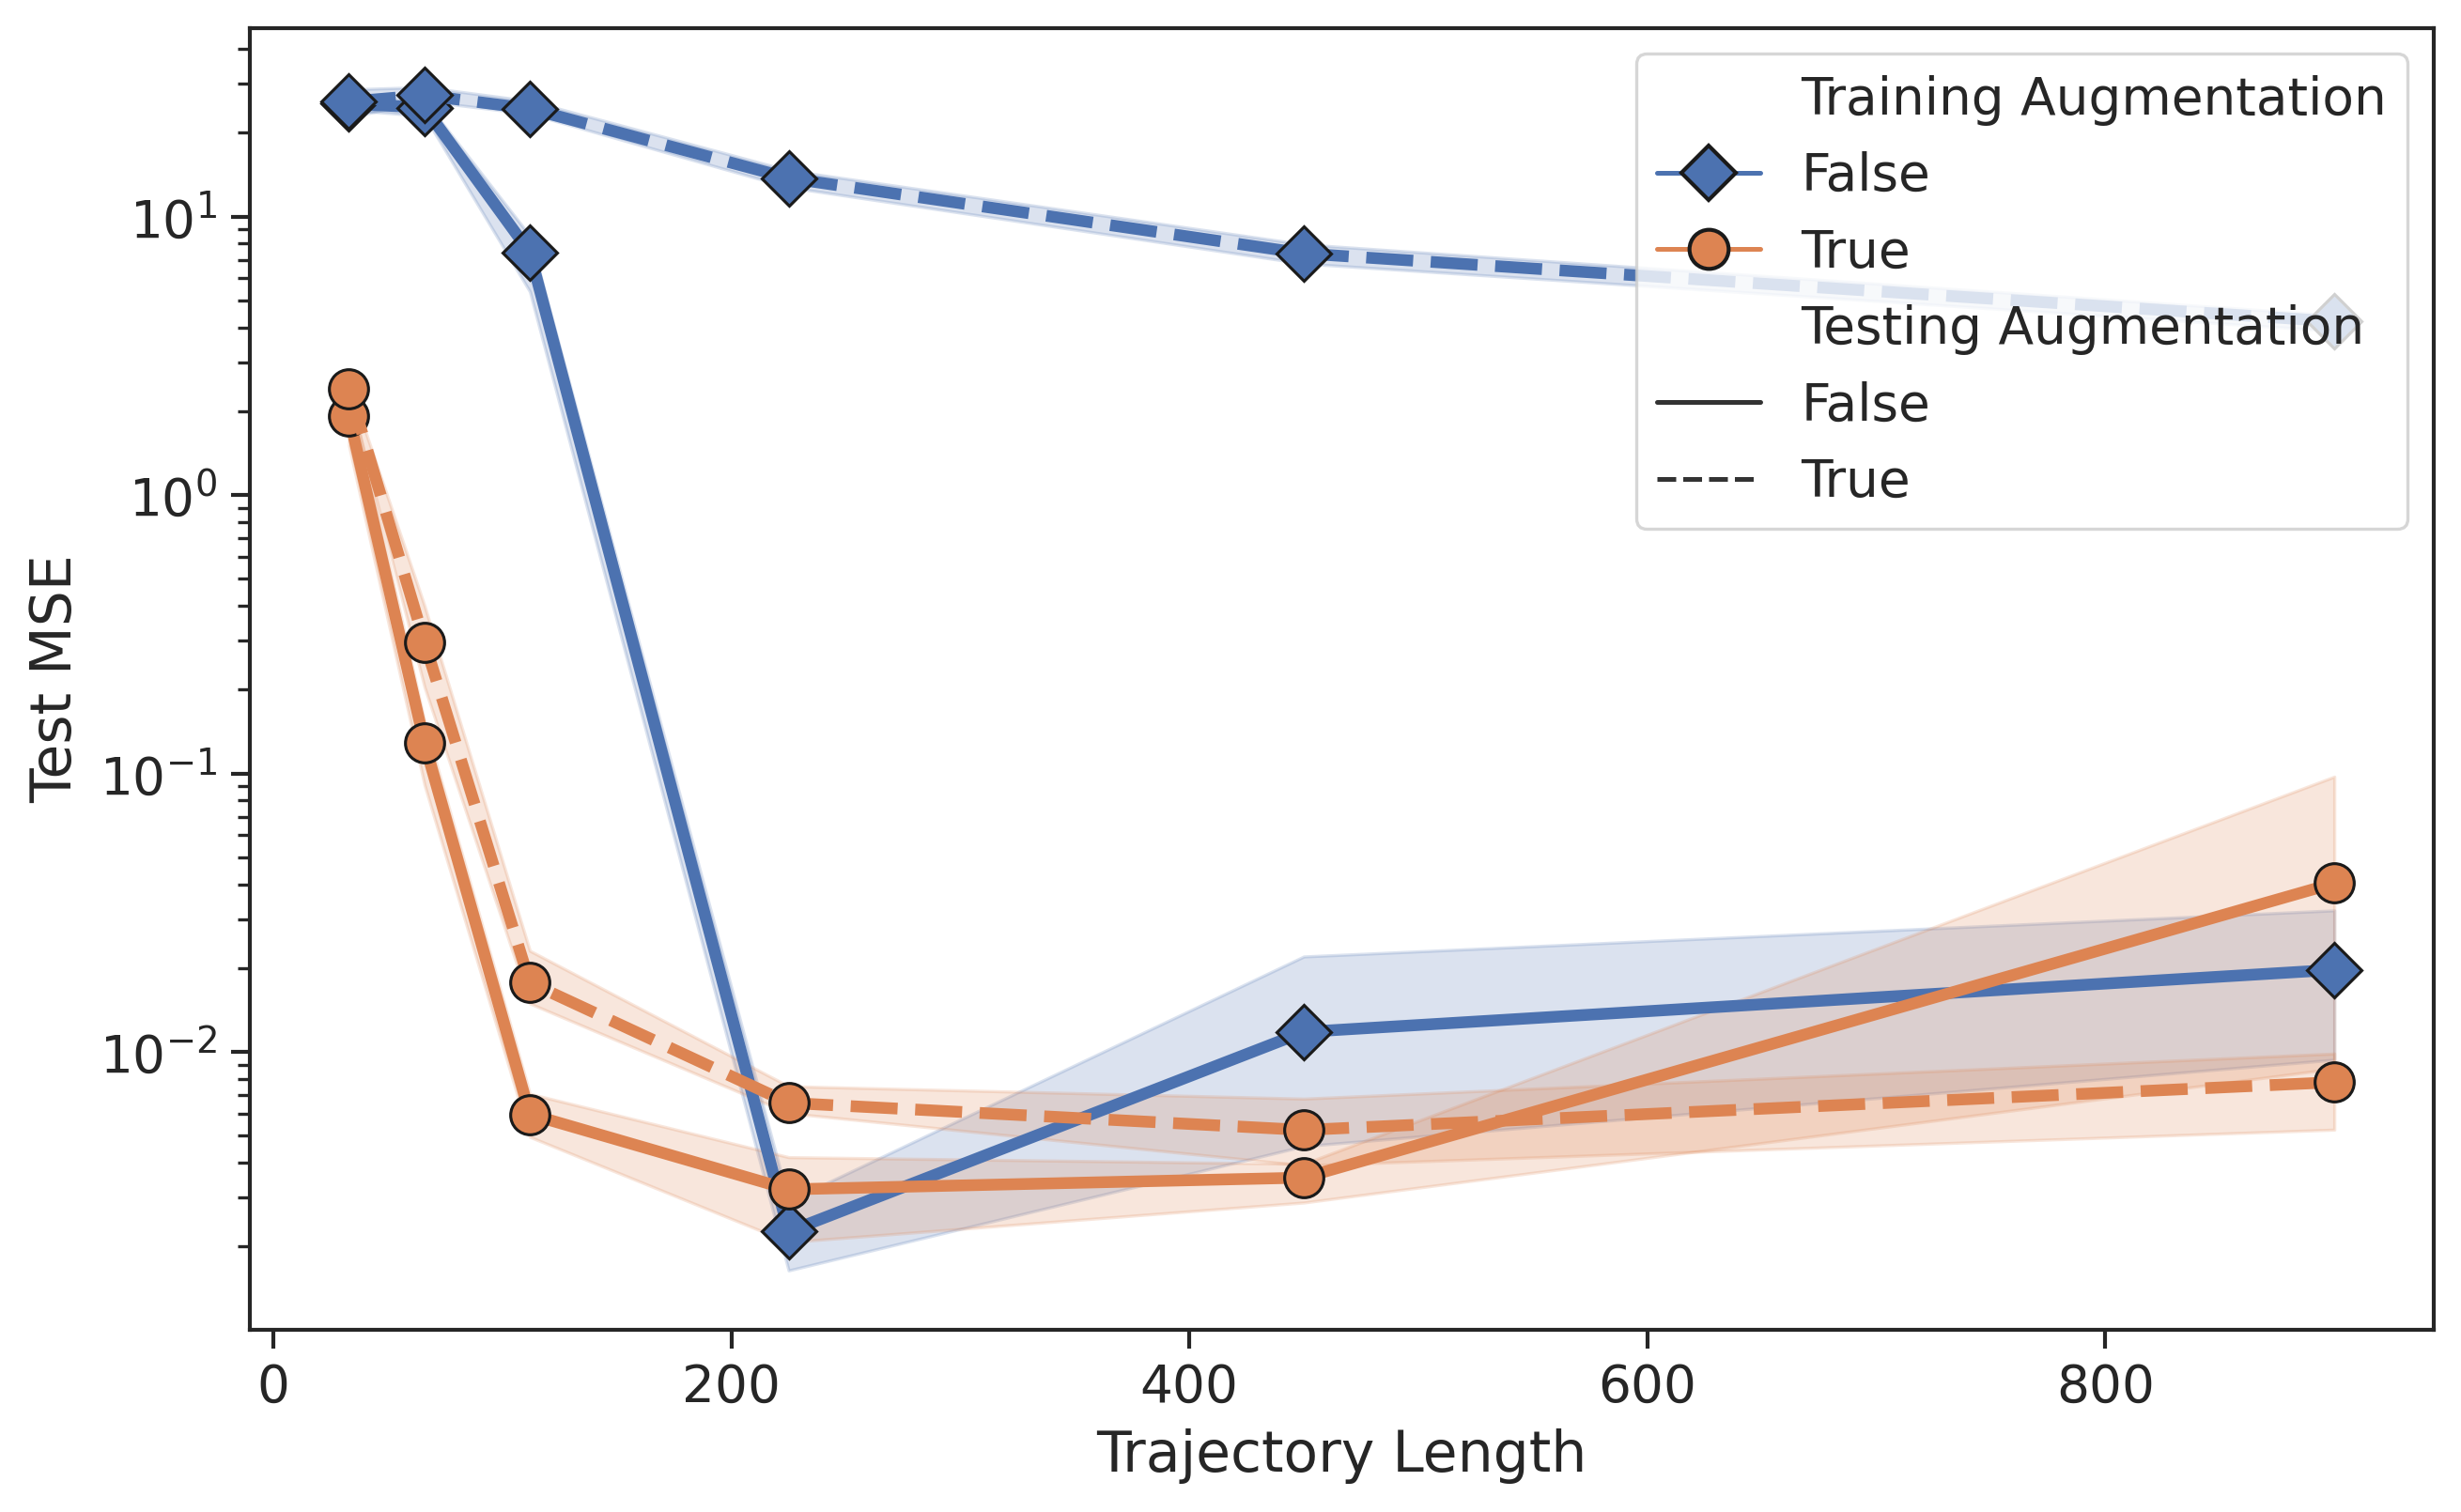

In [18]:
df = pd.read_csv("SAM_length_generalization_study.csv")

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=300)
plot = sns.lineplot(data=df, x="traj_len", y="Loss", hue="Training Augmentation", style="Testing Augmentation", ax=ax,
     linewidth=3, markers=True, markeredgecolor='k')
fix_lineplot_markers(plot)
ax.set_yscale('log')
ax.set_xlabel("Trajectory Length")
ax.set_ylabel("Test MSE")
ax.legend(loc='upper right')
fig.savefig("SAM_trajectory_length_study.pdf", bbox_inches="tight")